# Imports

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from ta.trend import TRIXIndicator
from ta.trend import WMAIndicator
from ta.trend import CCIIndicator
from ta.volume import money_flow_index
import pandas_ta as pta
from ta.trend import MACD
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.volume import ChaikinMoneyFlowIndicator
from ta.trend import ADXIndicator

# Load Data

In [13]:
# List of stocks which should be in the training data

stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'PYPL', 'INTC', 'ADBE']

### Download data from Yahoo Finance

In [21]:
def download_stock_data(symbols):
    """
    Herunterladen von Aktiendaten mit yfinance und Speichern in CSV-Dateien.

    Parameter:
    - symbols: Eine Liste von Aktiensymbolen (z.B. ['AAPL', 'MSFT', 'GOOGL'])

    Rückgabewert:
    - None
    """
    for symbol in symbols:
        data = yf.download(symbol, period = 'max')
        file_path = os.path.join('data', f'{symbol}.csv')
        data.to_csv(file_path)
        
        print(f'Aktiendaten für {symbol} heruntergeladen und in {file_path} gespeichert.')

In [22]:
download_stock_data(stocks)

[*********************100%%**********************]  1 of 1 completed


Aktiendaten für AAPL heruntergeladen und in data/AAPL.csv gespeichert.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Aktiendaten für MSFT heruntergeladen und in data/MSFT.csv gespeichert.
Aktiendaten für GOOGL heruntergeladen und in data/GOOGL.csv gespeichert.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Aktiendaten für AMZN heruntergeladen und in data/AMZN.csv gespeichert.
Aktiendaten für TSLA heruntergeladen und in data/TSLA.csv gespeichert.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Aktiendaten für NVDA heruntergeladen und in data/NVDA.csv gespeichert.
Aktiendaten für PYPL heruntergeladen und in data/PYPL.csv gespeichert.


[*********************100%%**********************]  1 of 1 completed


Aktiendaten für INTC heruntergeladen und in data/INTC.csv gespeichert.


[*********************100%%**********************]  1 of 1 completed

Aktiendaten für ADBE heruntergeladen und in data/ADBE.csv gespeichert.


### Create dataframes for each stock

In [28]:
def create_dataframes():
    """
    Erstellt pro CSV-Datei einen DataFrame mit dem Namen der Aktie.

    Rückgabewert:
    - dataframes: Ein Dictionary, das die DataFrames enthält, wobei die Schlüssel die Aktiennamen sind.
    """
    dataframes = {}
    data_folder = 'data'

    # Durchlaufen aller CSV-Dateien im `data`-Ordner
    for file_name in os.listdir(data_folder):
        if file_name.endswith('.csv'):
            # Aktienname aus dem Dateinamen extrahieren (ohne '.csv')
            stock_name = os.path.splitext(file_name)[0]
            
            # DataFrame aus der CSV-Datei erstellen und im Dictionary speichern
            df = pd.read_csv(os.path.join(data_folder, file_name))
            dataframes[stock_name] = df
    return dataframes

# Beispielaufruf
dataframes = create_dataframes()
print(dataframes.keys())  # Ausgabe der Aktiennamen, die als Schlüssel im Dictionary gespeichert sind


dict_keys(['ADBE', 'AMZN', 'INTC', 'PYPL', 'MSFT', 'NVDA', 'TSLA', 'GOOGL', 'AAPL'])


# Create Features

### Function Template for feature creation

In [4]:
def get_NAME_FEATUERE(df):
    #implementation of the feature-calculation
    # directly add the feature to the dataframe
    # no reurn needed
    pass

### Window Parameter

In [31]:
window = [5,7,9,11,13,15,17,19,21]

## Simple Moving Average SMA

In [32]:
def get_SMA(df):
    for i in window:
        df[f"SMA_{i}"] = df['Close'].rolling(window=i).mean()

## Exponential Moving Average

In [33]:
# a function for the exponential moving average
def get_EMA(df):
    for i in window:
        df[f"EMA_{i}"] = df['Close'].ewm(span=i, adjust=False).mean()   # adjust checken: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

## Triple Exponential Moving Average (TEMA)

In [34]:
def get_TRIX(df):
    for i in window:
        trix_values = TRIXIndicator(df['Close'], i).trix()
        df[f"TRIX_{i}"] = trix_values
    return df

## Mony Flow Index

The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100.

https://www.investopedia.com/terms/m/mfi.asp

In [35]:
# Function to calculate Money Flow Index
# Uses monex_flow_index from ta library

def get_MFI(df):
    for i in window:
        df[f"money_flow_index_{i}"] = money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], window=i)  

## Smoothed RSI

In [36]:
def get_RSI_smooth(df):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )

    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """

    prev_rsi = np.inf
    prev_avg_gain = np.inf
    prev_avg_loss = np.inf
    rolling_count = 0

    def calculate_RSI(series, period):
        # nonlocal rolling_count
        nonlocal prev_avg_gain
        nonlocal prev_avg_loss
        nonlocal rolling_count

        # num_gains = (series >= 0).sum()
        # num_losses = (series < 0).sum()
        # sum_gains = series[series >= 0].sum()
        # sum_losses = np.abs(series[series < 0].sum())
        curr_gains = series.where(series >= 0, 0)  # replace 0 where series not > 0
        curr_losses = np.abs(series.where(series < 0, 0))
        avg_gain = curr_gains.sum() / period  # * 100
        avg_loss = curr_losses.sum() / period  # * 100
        rsi = -1

        if rolling_count == 0:
            # first RSI calculation
            rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
            # print(rolling_count,"rs1=",rs, rsi)
        else:
            # smoothed RSI
            # current gain and loss should be used, not avg_gain & avg_loss
            rsi = 100 - (100 / (1 + ((prev_avg_gain * (period - 1) + curr_gains.iloc[-1]) /
                                     (prev_avg_loss * (period - 1) + curr_losses.iloc[-1]))))
            # print(rolling_count,"rs2=",rs, rsi)

        # df['rsi_'+str(period)+'_own'][period + rolling_count] = rsi
        rolling_count = rolling_count + 1
        prev_avg_gain = avg_gain
        prev_avg_loss = avg_loss
        return rsi

    diff = df['Close'].diff()[1:]  # skip na
    for i in window:
        df['rsi_' + str(i)] = np.nan
        # df['rsi_'+str(period)+'_own_1'] = np.nan
        rolling_count = 0
        res = diff.rolling(i).apply(calculate_RSI, args=(i,), raw=False)
        df['rsi_' + str(i)][1:] = res

## Williams %R

https://de.wikipedia.org/wiki/Williams_%25R

In [37]:
def get_WILLIAMS_R(df):
    for i in window:
        highest_high = df['High'].rolling(window=i).max()
        lowest_low = df['Low'].rolling(window=i).min()
        df[f"williams_r_{i}"] = ((highest_high - df['Close']) / (highest_high - lowest_low)) * (-100)

## WMA - Weighted Moving Average

In [38]:
def get_WMA(df):
    for i in window:
        df[f"wma_{i}"] = WMAIndicator(df['Close'], i).wma()

## HMA - Hull Moving Average

In [39]:
#  ToDo: Formel und Resultate noch zu validieren!!

def get_HMA(df):
    """
    Berechnet den Hull Moving Average (HMA) und fügt ihn als neue Spalte zum DataFrame hinzu.
    
    """

    for i in window:
        wma1 = 2 * df['Close'].rolling(window=int(i / 2)).mean()
        wma2 = df['Close'].rolling(window=i).mean()
        diff = wma1 - wma2
        hma = diff.rolling(window=int(np.sqrt(i))).mean()
        df[f"hma_{i}"] = hma


## CCI - Commodity Channel Index

In [40]:
def get_CCI(df):
    for i in window:
        cci_values = CCIIndicator(df['High'], df['Low'], df['Close'], i).cci()
        df[f"cci_{i}"] = cci_values

## CMO - Chande Momentum Oszillator

In [41]:
# https://github.com/twopirllc/pandas-ta?tab=readme-ov-file#trend-18
# ToDo: Check!

def get_CMO(df):
    for i in window:
        df[f"cmo_{i}"] = pta.cmo(df['Close'], length=i)

## MACD - Moving Average Convergence Divergence

In [42]:
## https://www.lynxbroker.ch/boerse/trading/technische-analyse/technische-indikatoren/der-macd-indikator-bestimmen-sie-die-richtung-und-staerke-des-trends/

In [43]:
# ToDo: Check and Implementation for different windows

def get_MACD(df):
    macd_object = MACD(df['Close'])
    df['MACD'] = macd_object.macd()
    df['MACD_Signal'] = macd_object.macd_signal()
    df['MACD_Diff'] = macd_object.macd_diff()

## PPO - Percentage Price Oscillator

https://school.stockcharts.com/doku.php?id=technical_indicators:price_oscillators_ppo

In [44]:
# ToDo: Check and Implementation for different windows

def get_PPO(df):
        ppo_object = PercentagePriceOscillator(df['Close'])
        df[f"PPO"] = ppo_object.ppo()
        df[f"PPO_Histogram"] = ppo_object.ppo_hist()
        df[f"PPO_Signal"] = ppo_object.ppo_signal()

## ROC - Rate of Change

https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum

In [45]:
def get_ROC(df):
    for i in window:
        df[f"ROC_{i}"] = ROCIndicator(df['Close'], i).roc()

## CMI - Chaikin Money Flow

https://school.stockcharts.com/doku.php?id=technical_indicators:chaikin_money_flow_cmf

In [46]:
def get_CMF(df):
    for i in window:
        df[f"cmf_{i}"] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], i).chaikin_money_flow()

## ADX - Average Directional Movement Index (ADX)

http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx

In [47]:
def get_ADX(df):
    for i in window:
        df[f"adx_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx()
        df[f"adx_pos_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_pos()
        df[f"adx_neg_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_neg()
        
        

## Calculation of all features

In [49]:
def create_features(df):
    get_SMA(df)
    get_EMA(df)
    get_TRIX(df)
    get_MFI(df)
    get_RSI_smooth(df)
    get_WILLIAMS_R(df)
    get_WMA(df)
    get_HMA(df)
    get_CCI(df)
    get_CMO(df)
    get_MACD(df)
    get_PPO(df)
    get_ROC(df)
    get_CMF(df)
    get_ADX(df)
    
    print('Feature creation done!')

In [50]:
# calculate features for all dataframes

for df in dataframes:
    create_features(dataframes[df])

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi_' + str(i)][1:] = res
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/674612428.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Feature creation done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/476938937.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"adx_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx()
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/476938937.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"adx_pos_{i}"] = ADXIndicator(df['High'], df['Low'], df['Close'], i).adx_pos()
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/476938937.py:5: PerformanceWarning: DataFrame is highly f

### Example DF

In [52]:
dataframes['AAPL'].head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_7,SMA_9,...,adx_neg_15,adx_17,adx_pos_17,adx_neg_17,adx_19,adx_pos_19,adx_neg_19,adx_21,adx_pos_21,adx_neg_21
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.119420,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,0.118973,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,0.121094,0.122210,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106524,46950400,0.126116,0.123565,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112130,48003200,0.132031,0.126913,0.126488,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.122481,55574400,0.139955,0.133450,0.129836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Labeling

In [37]:
# Function to lable the data
# if i + 11 is the max value in the window, label as BUY
# if i + 11 is the min value in the window, label as SELL
# else label as HOLD
# Idea: Buy when the stock is at its lowest in the window, sell when it is at its highest

# Source: https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3


def get_labels_END(df, windowSize=11):
   labels = [] 
   values = []
   for i in range(len(df.Close) - windowSize): 
      mx = df.Close.iloc[i]
      mn = df.Close.iloc[i]
      mxIndex, mnIndex = i, i
      for j in range(i + 1, i + windowSize + 1): 
         if df.Close.iloc[j] > mx:
               mx = df.Close.iloc[j]
               mxIndex = j
         if df.Close.iloc[j] < mn: 
               mn = df.Close.iloc[j] 
               mnIndex = j

      if mnIndex == i + 11:
         labels.append('SELL')
         values.append(i + 11)
      elif mxIndex == i + 11:
         labels.append('BUY')
         values.append(i + 11)
      else:
         labels.append('HOLD')
         values.append(i + 11)
   
   # Append 11 times a 999 to the end of the labels list
   for i in range(11):
      labels.append(999)

   # Append the labels to the dataframe from the start
   df['Labels_END'] = labels

   # Replace the 999 with NaN
   df['Labels_END'] = df['Labels_END'].replace(999, np.nan)

   print('Labeling END done!')

   return df


In [56]:
# Source: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3


def get_labels_MID(df, col_name, window_size=11):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : nothing - df is modified directly
        """

        row_counter = 0
        total_rows = len(df)
        labels = np.zeros(total_rows)
        labels[:] = np.nan

        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = int((window_begin + window_end) / 2)

                min_ = np.inf
                min_index = -1
                max_ = -np.inf
                max_index = -1
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < min_:
                        min_ = price
                        min_index = i
                    if price > max_:
                        max_ = price
                        max_index = i

                if max_index == window_middle:
                    labels[window_middle] = 0
                elif min_index == window_middle:
                    labels[window_middle] = 1
                else:
                    labels[window_middle] = 2

            row_counter = row_counter + 1

        # Add labels to the dataframe
        df['Labels_MID'] = labels

        # Replace the 0, 1, 2 with BUY, SELL, HOLD
        df['Labels_MID'] = df['Labels_MID'].replace(0, 'SELL')
        df['Labels_MID'] = df['Labels_MID'].replace(1, 'BUY')
        df['Labels_MID'] = df['Labels_MID'].replace(2, 'HOLD')
        

        print('Labeling MID done!') 

In [57]:
# Create Labels for all dataframes
for df in dataframes:
    get_labels_MID(dataframes[df], 'Close')

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels


Labeling MID done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels


Labeling MID done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Labeling MID done!
Labeling MID done!
Labeling MID done!
Labeling MID done!
Labeling MID done!
Labeling MID done!
Labeling MID done!


/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Labels_MID'] = labels
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/1539600692.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

### Plots

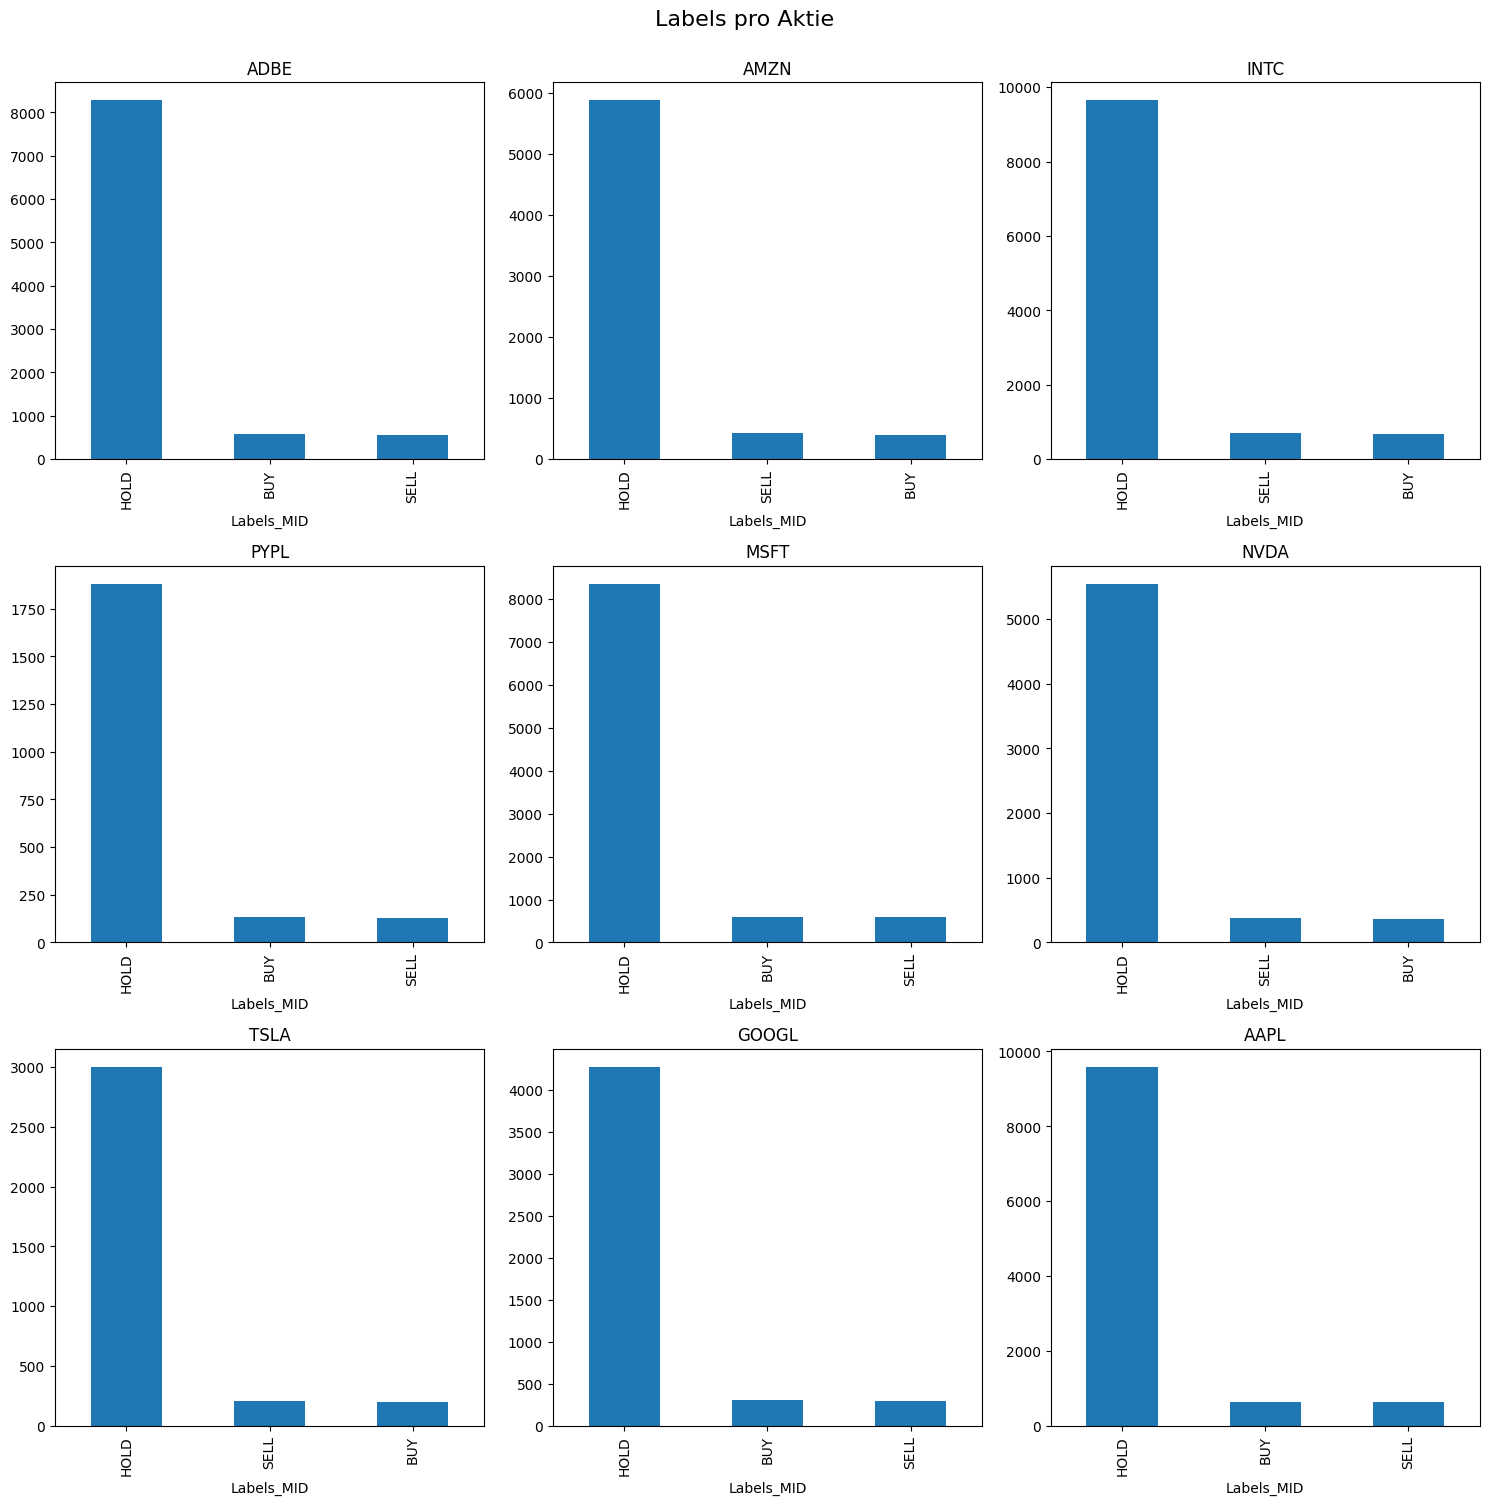

In [121]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, (stock, df) in enumerate(dataframes.items()):
    df['Labels_MID'].value_counts().plot(kind='bar', ax=axs[i], title=stock)

fig.suptitle('Labels pro Aktie', fontsize=16, y=1.0005)

plt.tight_layout()
plt.show()


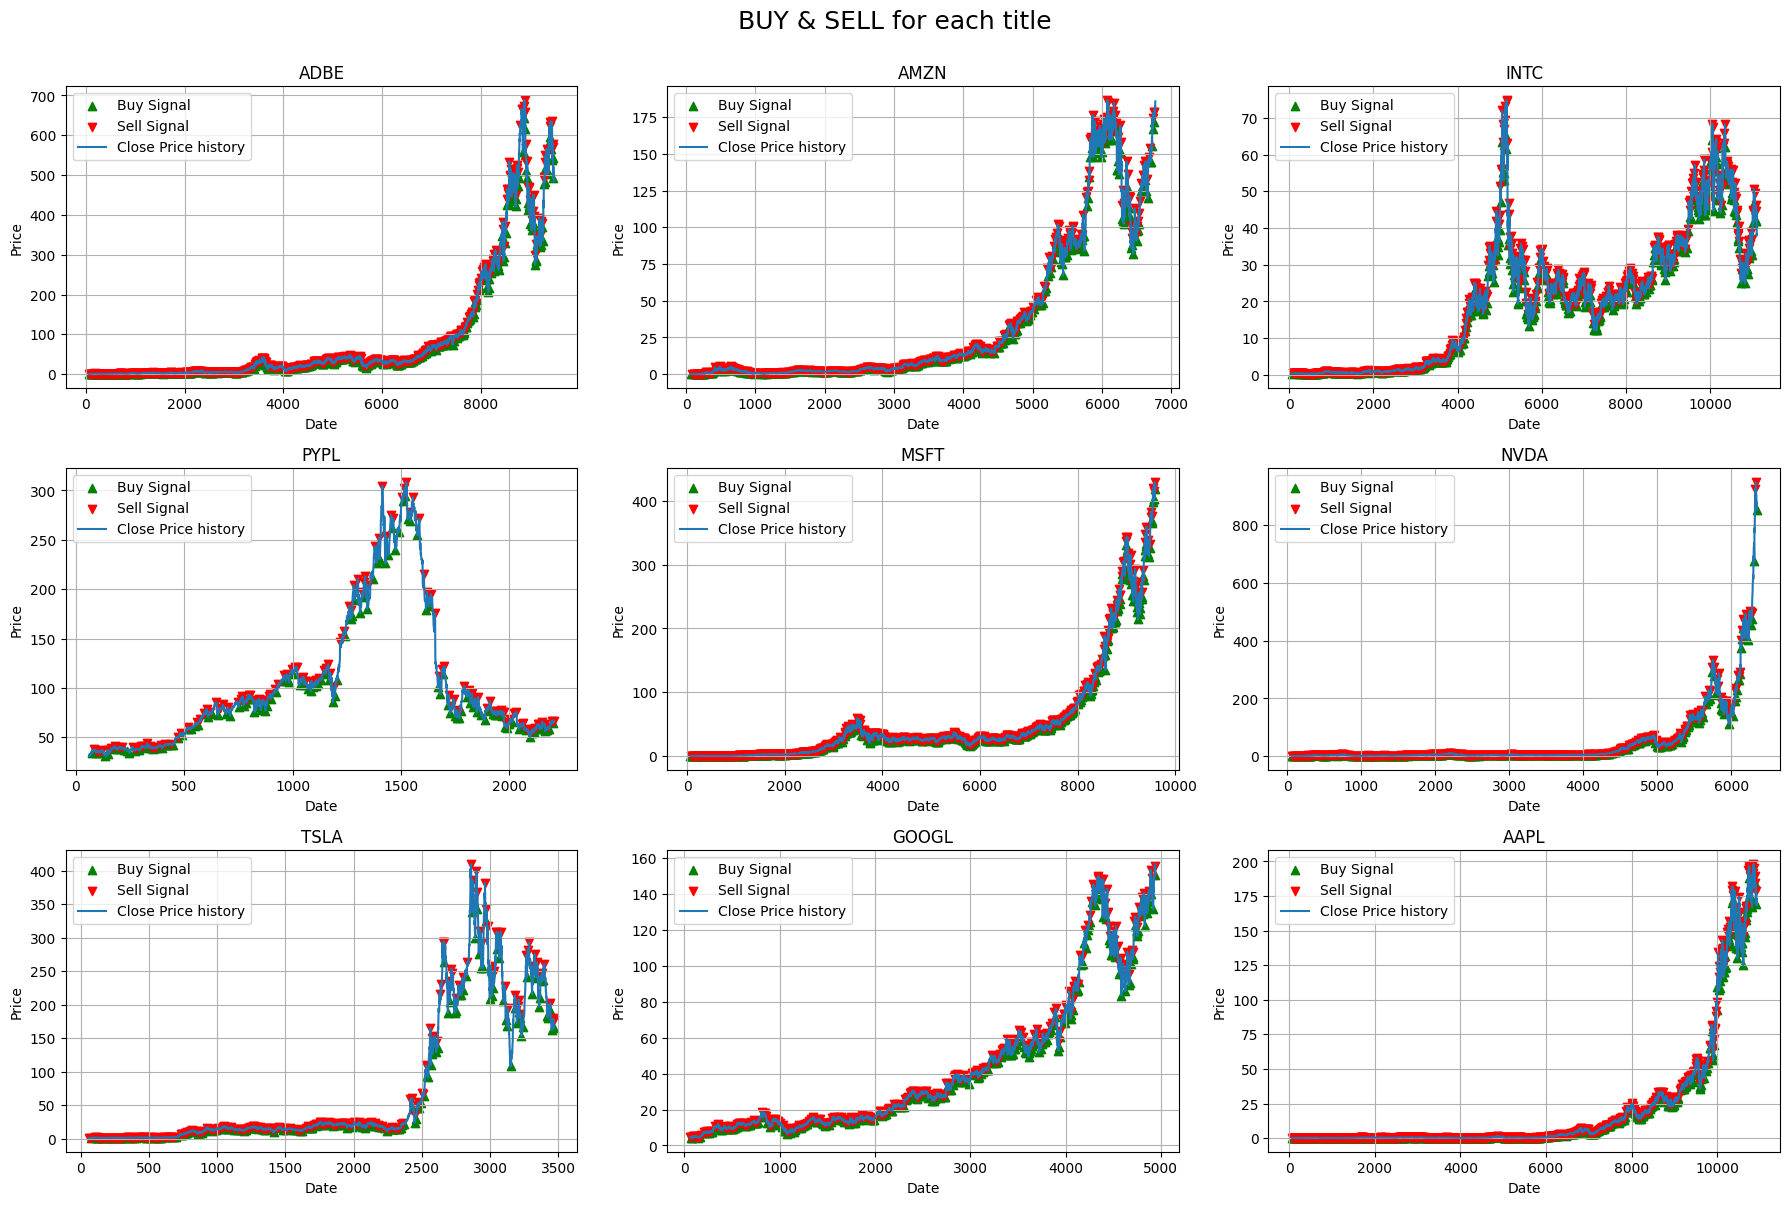

In [148]:
def plot_stock_price(dataframes):
    num_plots = len(dataframes)
    num_rows = (num_plots + 2) // 3 

    fig, axs = plt.subplots(num_rows, 3, figsize=(18, 4 * num_rows))
    axs = axs.flatten()

    for i, (stock_name, df) in enumerate(dataframes.items()):
        ax = axs[i]
        buy = df[df['Labels_MID'] == 'BUY']
        sell = df[df['Labels_MID'] == 'SELL']
        ax.scatter(buy.index, buy['Close'], color='g', label='Buy Signal', marker='^', alpha=1)
        ax.scatter(sell.index, sell['Close'], color='r', label='Sell Signal', marker='v', alpha=1)

        ax.plot(df['Close'], label='Close Price history')
        ax.set_title(f'{stock_name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(loc='upper left')
        ax.grid()
        fig.suptitle('BUY & SELL for each title', fontsize=18, y=1.0005)


    plt.tight_layout()
    plt.show()

# Aufruf der Funktion
plot_stock_price(dataframes)


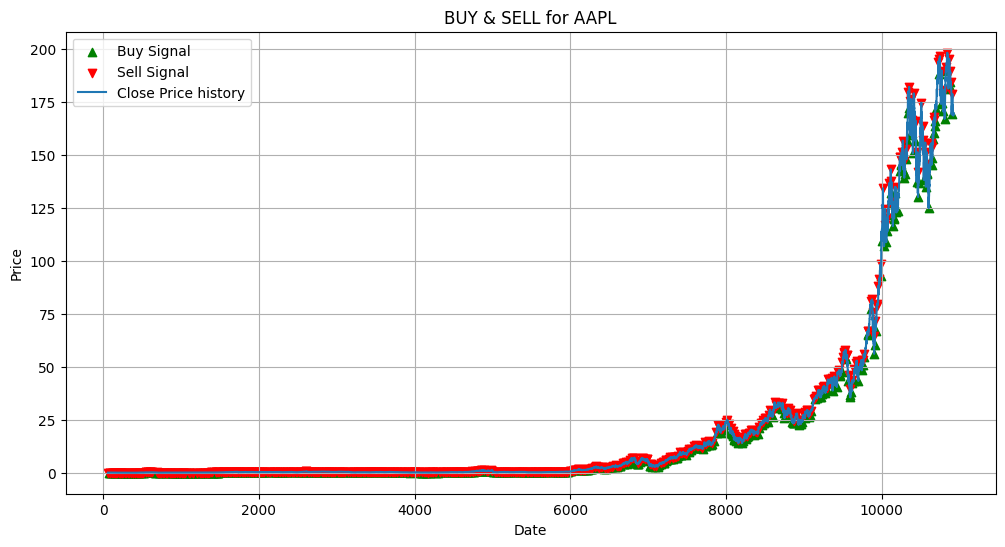

In [149]:
# function to create a single plot

def plot_single_stock_price(stock_name):
    df = dataframes[stock_name]
    fig, ax = plt.subplots(figsize=(12, 6))
    buy = df[df['Labels_MID'] == 'BUY']
    sell = df[df['Labels_MID'] == 'SELL']
    ax.scatter(buy.index, buy['Close'], color='g', label='Buy Signal', marker='^', alpha=1)
    ax.scatter(sell.index, sell['Close'], color='r', label='Sell Signal', marker='v', alpha=1)

    ax.plot(df['Close'], label='Close Price history')
    ax.set_title(f'BUY & SELL for {stock_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    ax.grid()
    plt.show()

# Aufruf der Funktion
plot_single_stock_price('AAPL')


## Feature Engineering

The reason behind having this step in our pipeline is that Feature engineering involves creating, transforming, or selecting the most relevant variables in your dataset to improve model performance. This process is critical because it enables the model to learn from the data more effectively, leading to better predictions and insights. Feature selection, in particular, trims down the feature set to keep only the most valuable attributes, reducing complexity, computation time, and the risk of overfitting. In essence, these techniques streamline the modelling process, making it more accurate, interpretable, and efficient, while also saving time and resources.
First, we Normalize our data set because Normalizing a dataset is crucial to ensure that all features are on a consistent scale, preventing one feature from dominating the analysis, improving model convergence, aiding in the interpretation of feature importance, making distance-based algorithms more reliable, and aligning with assumptions of regularisation techniques, all of which contribute to more effective and robust data analysis and machine learning.
Then we will just apply a small filter of variance with a threshold of 0.1 i.e. any feature which has a variance less than or equal to 0.1 will be removed from the dataset as having this low variance does not contribute much to detecting the trend in the dataset.

### Cleaning individual dataframes

In [59]:
# Drop the NaN values and 0.00 from the dataframe
for i in dataframes:
    dataframes[i].dropna(inplace=True)
    dataframes[i] = dataframes[i][dataframes[i]['Close'] != 0.00]

### Merge the dataframes

In [74]:
# merge the dataframes to one dataframe
# save it as a csv file
merged_df = pd.concat(dataframes)
merged_df = merged_df.set_index('Date')
merged_df.to_csv('merged_data/merged_data.csv')


### Encode the labels

In [76]:
# Encode the labels
# Manual encoding

merged_df['Labels_MID'] = merged_df['Labels_MID'].replace('BUY', 0)
merged_df['Labels_MID'] = merged_df['Labels_MID'].replace('SELL', 1)
merged_df['Labels_MID'] = merged_df['Labels_MID'].replace('HOLD', 2)

### Calculation of possible amount of features

In [80]:
# Function to calculate the number of features

def calc_feature_number(features):
    features = len(features)
    return np.floor(np.sqrt(features)).astype(int)

In [82]:
list_features = list(merged_df.loc[:, 'Open':'adx_neg_21'].columns)
print('Total number of features: ', len(list_features))
print('Largest number of features that can be used in the model: ', calc_feature_number(list_features))
print(f"k = {calc_feature_number(list_features)**2}")

Total number of features:  147
Largest number of features that can be used in the model:  12
k = 144


### Train - Valid - Test Split and Normalization

In [155]:
### just copied from: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3
### needs to be reworked and adapted to the features we want to use
### create function for this


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter

df = merged_df.dropna()

list_features = list(df.loc[:, 'Open':'adx_neg_21'].columns)  # needs to be changed to the features you want to use
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'Open':'adx_neg_21'], df['Labels_MID'], train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['Labels_MID'])

train_split = 0.8

print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Total number of features 147
train_split = 0.8
Shape of x, y train/cv/test (41148, 147) (41148,) (10287, 147) (10287,) (12859, 147) (12859,)


# Feature Selection

Now the main part is that we will calculate the importance of each feature by using Random Forest Classifier and then reduce the feature size to 81.

A rough idea of how random forest works is for each decision point (split) in each tree, the Random Forest algorithm measures the decrease in impurity(Gini impurity) resulting from the split. The impurity reduction brought about by each feature is averaged across all the trees in the forest. Features that consistently reduce impurity more effectively when used in splits are considered more important

In [156]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [157]:
from sklearn.feature_selection import SelectKBest, chi2

# Anwenden der Feature Selection mit SelectKBest und Chi-Quadrat-Test
k = 100  # Anzahl der gewünschten Merkmale
selector = SelectKBest(chi2, k=k)
X_new = selector.fit_transform(x_train, y_train)

# Index der ausgewählten Merkmale
selected_feature_indices = selector.get_support(indices=True)

# Ausgabe der Indizes der ausgewählten Merkmale
print("Indizes der ausgewählten Merkmale:")
print(selected_feature_indices)

Indizes der ausgewählten Merkmale:
[  3   5  24  25  26  27  28  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  98  99
 100 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146]


In [158]:
len(selected_feature_indices)

100

In [159]:
# only use the selected features
x_train = x_train[:, selected_feature_indices]
x_cv = x_cv[:, selected_feature_indices]
x_test = x_test[:, selected_feature_indices]

## Feature Importamce in Prediction

Used mutual info classification for creating heat map for our image. Basically it tells us which part of the image is most useful to the model (will explain this part more in further ). (https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3)

> keine Ahnung was er damit meint und warum er das macht??!

## Image Creation

In [160]:
# Function to reshape the data
# Creates a 3D array (x, y and images for each row) for the CNN

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

In [161]:
dim = int(np.sqrt(k))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_cv: {x_cv.shape}')
print(f'Shape of x_test: {x_test.shape}')




final shape of x, y train/test (41148, 10, 10, 3) (41148,) (12859, 10, 10, 3) (12859,)
Shape of x_train: (41148, 10, 10, 3)
Shape of x_cv: (10287, 10, 10, 3)
Shape of x_test: (12859, 10, 10, 3)


In [98]:
x_train.shape

(41148, 10, 10, 3)

/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_79014/408720151.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i].set_title(y_train[index])


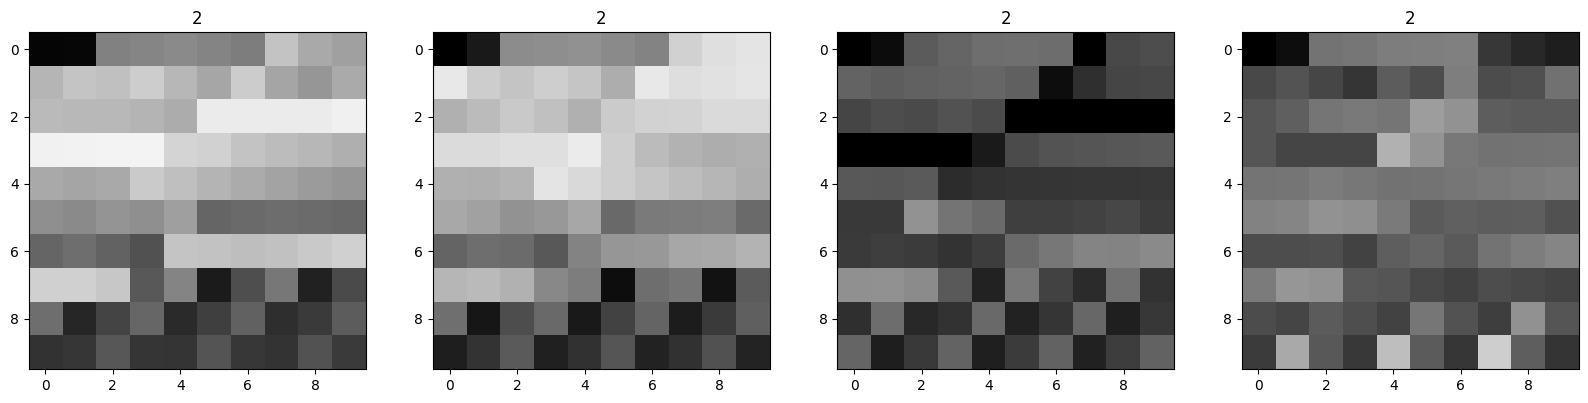

In [100]:
# Subplot with 4 plots in a row with random data

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    index = np.random.randint(0, x_train.shape[0])
    ax[i].imshow(x_train[index])
    ax[i].set_title(y_train[index])
plt.show()


## CNN

In [101]:
# compute class weights
counter = Counter(y_train)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
print('Class weights: ', class_weights)


Class weights:  {1: 14.358108108108109, 2: 1.0, 0: 14.409652971679298}


In [109]:
# a simple CNN model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],)


history = model.fit(x_train, y_train,
                    validation_data=(x_cv, y_cv),
                    epochs=200,
                    class_weight={0: class_weights[0], 1: class_weights[1], class_weights[2]: 2})


Epoch 1/200


/Users/flaviopfister/anaconda3/envs/banking/lib/python3.11/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


1286/1286 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6739 - loss: 1.3495 - val_accuracy: 0.7032 - val_loss: 0.6334
Epoch 2/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7047 - loss: 0.9751 - val_accuracy: 0.7174 - val_loss: 0.5352
Epoch 3/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7132 - loss: 0.9362 - val_accuracy: 0.6740 - val_loss: 0.5940
Epoch 4/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7077 - loss: 0.9245 - val_accuracy: 0.7297 - val_loss: 0.5601
Epoch 5/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7220 - loss: 0.9061 - val_accuracy: 0.6709 - val_loss: 0.5922
Epoch 6/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7040 - loss: 0.9280 - val_accuracy: 0.7202 - val_loss: 0.5767
Epoch 7/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7195 - loss: 0.9143 - val_accuracy: 0.7224 - val_loss: 0.5326
Epoch 8/200
1286/1286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7133 - loss: 0.9034 - val_

In [110]:
# calc the percentage of label 2 in validation data
print('Percentage of label 2 (HOLD) in validation data: ', Counter(y_cv)[2] / len(y_cv) * 100)

Percentage of label 2 (HOLD) in validation data:  87.79041508700301


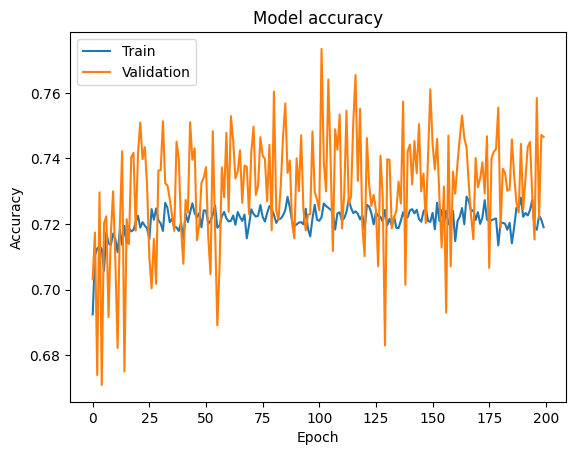

In [111]:
# plot the histrory of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


  1/322 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step

322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


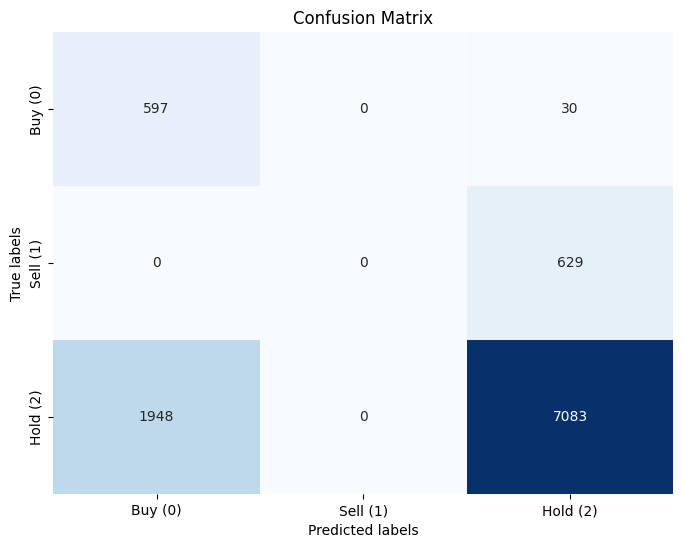

In [112]:
# ToDo: Checken!! Made with ChatGPT!!


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Vorhersagen für Validierungsdaten machen
y_pred = model.predict(x_cv)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix berechnen
conf_matrix = confusion_matrix(y_cv, y_pred_classes)

# Confusion Matrix plotten
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Buy (0)', 'Sell (1)', 'Hold (2)'], 
            yticklabels=['Buy (0)', 'Sell (1)', 'Hold (2)'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [113]:
# calculate the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_cv, y_pred_classes)
print('Accuracy on validation data: ', accuracy)


Accuracy on validation data:  0.7465733449985419


## Trading Bot Implementation